<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-CTD-χpod-data-and-convert-to-netCDF" data-toc-modified-id="Read-CTD-χpod-data-and-convert-to-netCDF-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read CTD χpod data and convert to netCDF</a></span></li><li><span><a href="#Read-transect-+-ancillary-datasets" data-toc-modified-id="Read-transect-+-ancillary-datasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read transect + ancillary datasets</a></span><ul class="toc-item"><li><span><a href="#plots" data-toc-modified-id="plots-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plots</a></span></li></ul></li><li><span><a href="#Calculate" data-toc-modified-id="Calculate-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate</a></span></li></ul></div>

# Read CTD χpod data and convert to netCDF

In [131]:
etopo = xr.open_dataset('/home/deepak/datasets/ETOPO2v2g_f4.nc4', autoclose=True).drop(180., 'x')
etopo = dcpy.oceans.dataset_center_pacific(etopo.rename({'x': 'lon', 'y': 'lat'}))

In [146]:
filename = '/home/deepak/work/eddydiff/datasets/P06/P06-means.mat'

mat = sp.io.loadmat(filename, squeeze_me=True)

p06 = xr.Dataset()

dims = ['cast', 'pres']
coords = {'cast': np.arange(300)+1, 'pres': mat['P'].astype(np.float32)}

for varname in ['chi', 'eps', 'Jq', 'KT', 'N2', 'dTdz', 'TPvar', 't', 's']:
    p06[varname] = xr.DataArray(mat[varname].T, dims=dims, coords=coords)
    
for varname in ['lat', 'lon', 'dnum', 'dist']:
    p06[varname] = xr.DataArray(mat[varname], dims=['cast'], coords={'cast':coords['cast']})

p06 = p06.rename({'t': 'T', 's': 'S', 'dnum': 'time'})
p06['time'].values = dcpy.util.datenum2datetime(p06['time'].values)
p06['rho'] = xr.DataArray(sw.dens(p06.S, p06['T'], p06['pres']), dims=dims, coords=coords)
p06 = p06.rename({'pres': 'P'})
# code expects P as pressure index vector; pres as actual 2D pressure
p06['pres'] = xr.broadcast(p06['cast'], p06['P'])[1]

p06 = p06.set_coords(['time', 'lon', 'lat', 'dist', 'pres'])

# reset co-ords to match ECCO/argo fields.
p06['lon'][p06.lon <= 0] += 360
p06 = p06.drop([1, 2], dim='cast')
p06 = p06.drop(np.arange(250, 301), dim='cast')

# fill in NaNs
p06['lon'] = p06.lon.interpolate_na(dim='cast')
p06['lat'] = p06.lat.interpolate_na(dim='cast')
p06['bathy'] = etopo.interp(lon=p06.lon, lat=p06.lat).z

p06.attrs['name'] = 'P06 merged dataset'
p06.attrs['transect_name'] = 'P06'
p06.to_netcdf('/home/deepak/work/eddydiff/datasets/P06/p06.nc')
p06

<xarray.Dataset>
Dimensions:  (P: 601, cast: 247)
Coordinates:
  * cast     (cast) int64 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 ...
  * P        (P) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 ...
    lat      (cast) float64 -30.08 -30.08 -30.08 -30.08 -30.08 -30.08 -30.08 ...
    lon      (cast) float64 153.6 153.7 153.7 153.8 153.9 154.0 154.0 154.2 ...
    time     (cast) datetime64[ns] 2017-07-04T15:05:44 2017-07-04T19:58:21 ...
    dist     (cast) float64 0.0 7.686 14.41 22.48 30.76 34.63 38.45 53.85 ...
    pres     (cast, P) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 ...
Data variables:
    chi      (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    eps      (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Jq       (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    KT       (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    N2       (cast, P) float64 nan nan nan nan nan

# Read transect + ancillary datasets

In [6]:
sys.path.append('../eddydiff/')
import eddydiff as ed

eccograd, argograd, cole = ed.read_all_datasets()

p06 = xr.open_dataset('/home/deepak/work/eddydiff/datasets/P06/p06.nc', autoclose=True)
bathy = p06.bathy.copy()
p06 = p06.where(p06['KT'] < 1e-2)
p06['bathy'] = bathy
p06['KtTz'] = p06.KT * p06.dTdz
p06

/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


<xarray.Dataset>
Dimensions:  (P: 601, cast: 247)
Coordinates:
  * cast     (cast) int64 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 ...
  * P        (P) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 ...
    lat      (cast) float64 -30.08 -30.08 -30.08 -30.08 -30.08 -30.08 -30.08 ...
    lon      (cast) float64 153.6 153.7 153.7 153.8 153.9 154.0 154.0 154.2 ...
    time     (cast) datetime64[ns] 2017-07-04T15:05:44 2017-07-04T19:58:21 ...
    dist     (cast) float64 0.0 7.686 14.41 22.48 30.76 34.63 38.45 53.85 ...
    pres     (cast, P) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 ...
Data variables:
    chi      (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    eps      (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Jq       (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    KT       (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    N2       (cast, P) float64 nan nan nan nan nan

## plots

/home/deepak/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/deepak/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:847: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/home/deepak/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:849: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


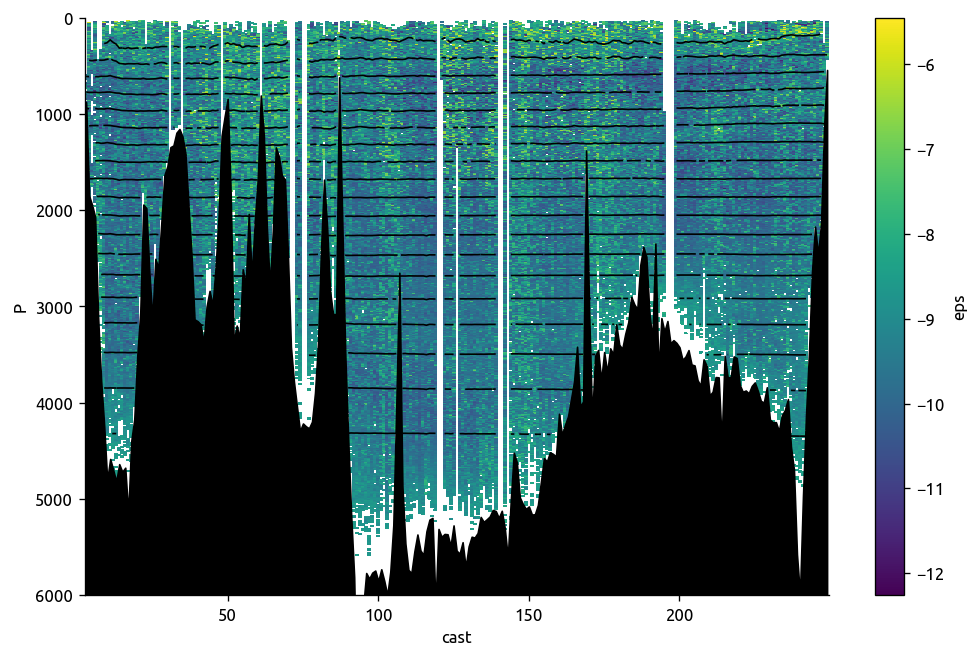

In [2]:
np.log10(p06.eps).plot(x='cast')
p06.rho.plot.contour(colors='k', x='cast', yincrease=False,
                     levels=pd.qcut(p06.rho.values.ravel(), 20, retbins=True)[1])
plt.gca().fill_between(p06.cast, 6100, -p06.bathy, color='k', zorder=10)
plt.gcf().set_size_inches(10, 10/1.6)

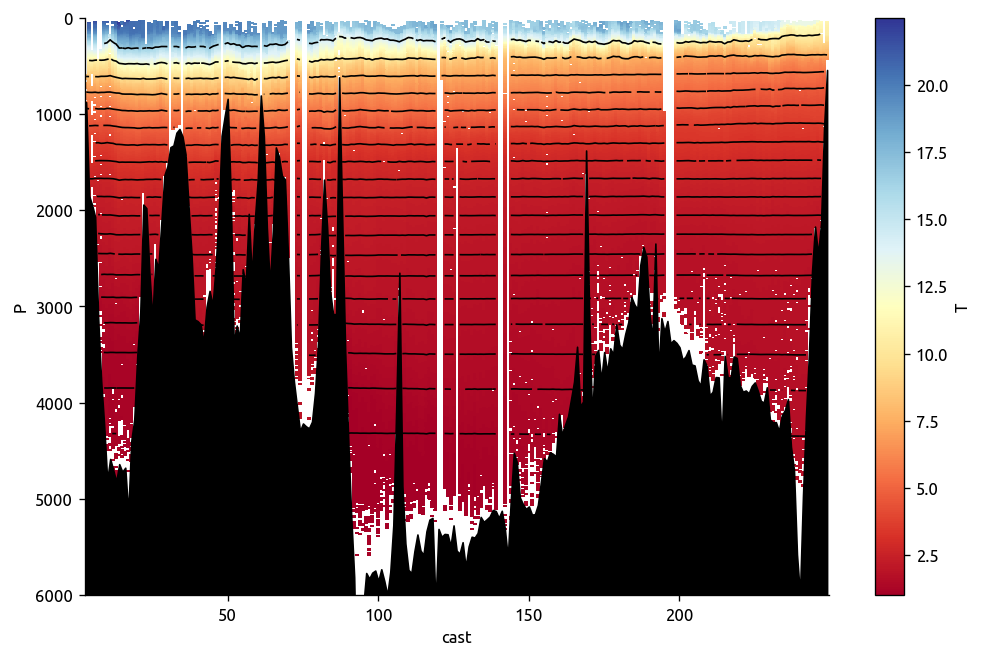

In [237]:
p06['T'].plot(x='cast', cmap=mpl.cm.RdYlBu)
p06.rho.plot.contour(colors='k', x='cast', yincrease=False,
                     levels=pd.qcut(p06.rho.values.ravel(), 20, retbins=True)[1])
plt.gca().fill_between(p06.cast, 6100, -p06.bathy, color='k', zorder=10)
plt.gcf().set_size_inches(10, 10/1.6)

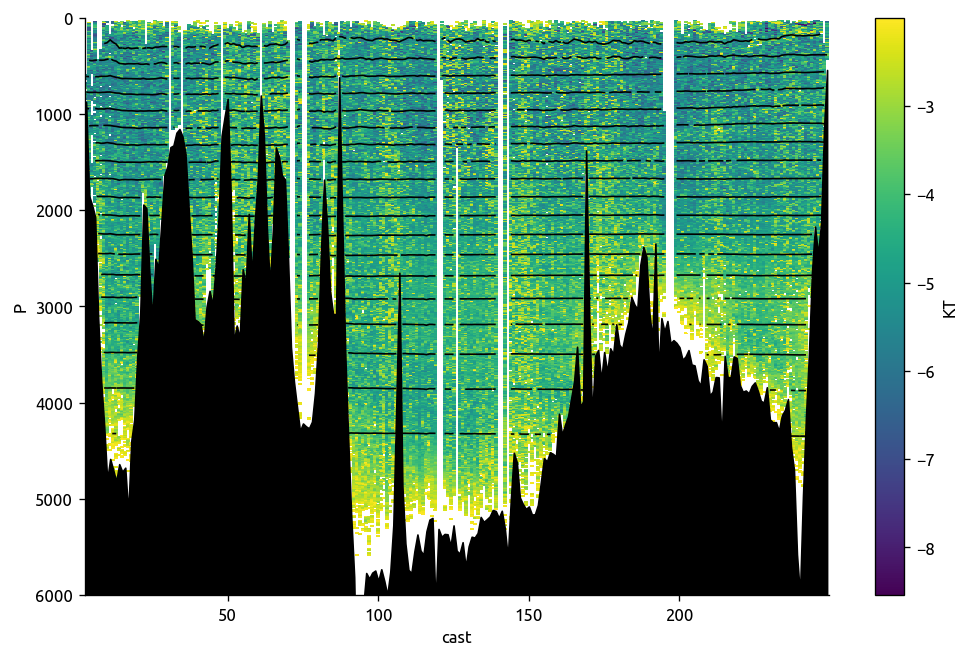

In [238]:
np.log10(p06['KT']).plot(x='cast')
p06.rho.plot.contour(colors='k', x='cast', yincrease=False,
                     levels=pd.qcut(p06.rho.values.ravel(), 20, retbins=True)[1])
plt.gca().fill_between(p06.cast, 6100, -p06.bathy, color='k', zorder=10)
plt.gcf().set_size_inches(10, 10/1.6)

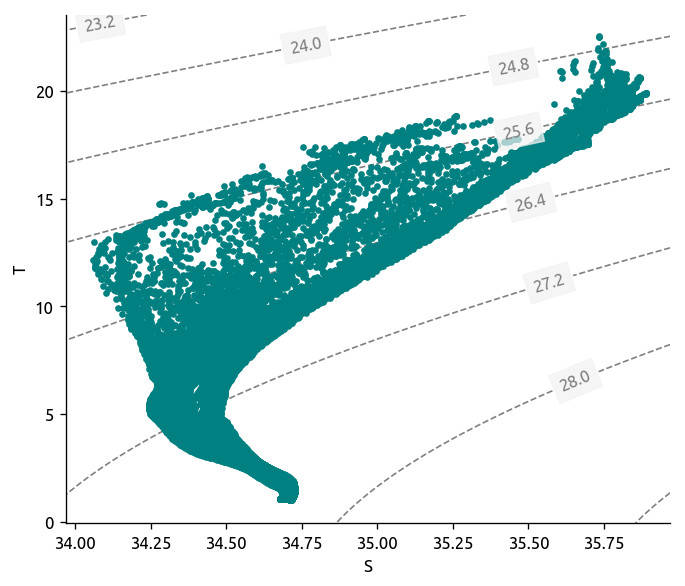

In [198]:
dcpy.oceans.TSplot(p06.S, p06['T'], p06.pres)

# Calculate

In [48]:
p06rho = ed.transect_to_density_space(p06.sel(P=slice(0,2000)))

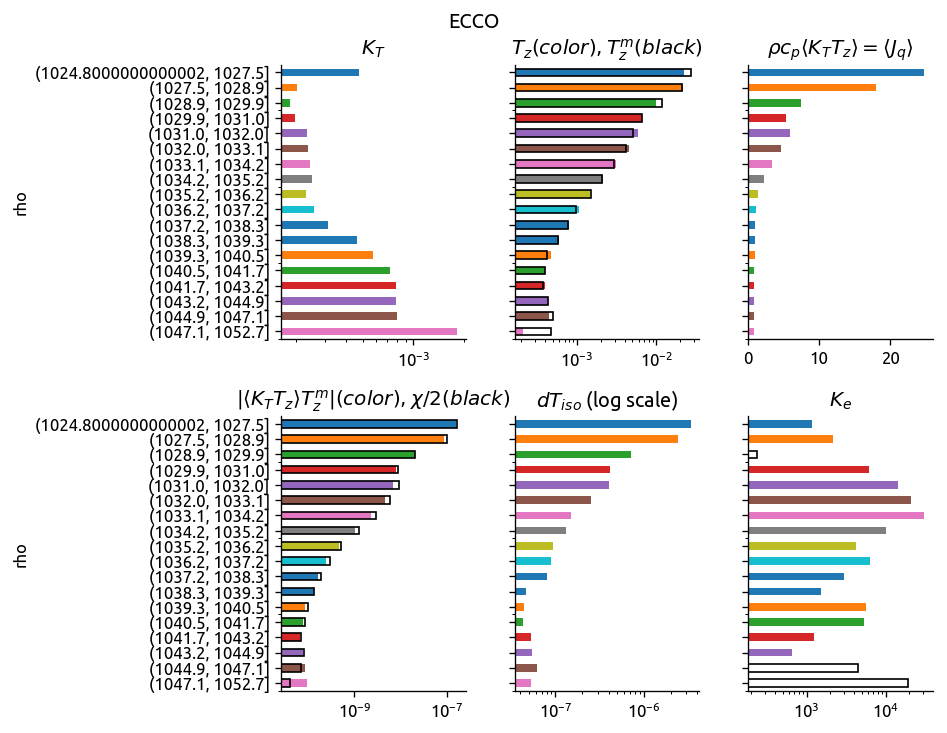

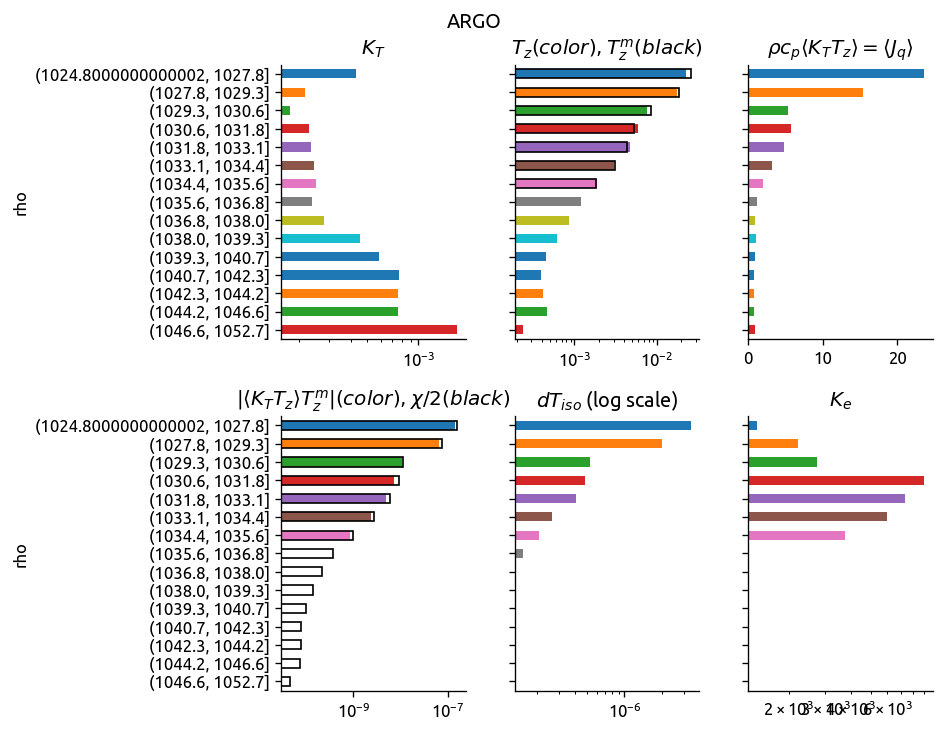

In [7]:
eccoKe = ed.process_transect_1d(p06, eccograd, 'ECCO', nbins=18)
ed.plot_bar_Ke(eccoKe)

argoKe = ed.process_transect_1d(p06, argograd, 'ARGO', nbins=15)
ed.plot_bar_Ke(argoKe)

In [232]:
pd.qcut(p06.rho.values.ravel(), 20, retbins=True, precision=1)

([NaN, NaN, NaN, NaN, NaN, ..., NaN, NaN, NaN, NaN, NaN]
 Length: 148447
 Categories (20, interval[float64]): [(1024.8000000000002, 1027.3] < (1027.3, 1028.6] < (1028.6, 1029.7] < (1029.7, 1030.6] ... (1042.7, 1044.1] < (1044.1, 1045.8] < (1045.8, 1047.9] < (1047.9, 1054.4]],
 array([1024.85109013, 1027.29282708, 1028.64797163, 1029.67706311,
        1030.63870863, 1031.6252916 , 1032.6240368 , 1033.61533749,
        1034.59303912, 1035.54415059, 1036.48941056, 1037.43564285,
        1038.40402199, 1039.38562174, 1040.42055114, 1041.52348615,
        1042.73058825, 1044.12533415, 1045.81093613, 1047.94573381,
        1054.35945173]))

In [188]:
cole.diffusivity.sel(**ed.get_region_from_transect(p06))

<xarray.DataArray 'diffusivity' (lat: 2, lon: 134, pres: 101)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lon      (lon) float64 154.5 155.5 156.5 157.5 158.5 159.5 160.5 161.5 ...
  * lat      (lat) float64 -32.0 -31.0
  * pres     (pres) float64 0.0 20.0 40.0 60.0 80.0 100.0 120.0 140.0 160.0 ...
Attributes:
    units:      m^2/s
    long_name:  eddy diffusivity on depth surfaces

In [178]:
clim = eccograd
transect = p06.sel(P=slice(0, 2000))

trmean, ρbins = ed.average_transect_1d(transect, nbins=20)
gradmean = ed.average_clim(clim, transect, ρbins)

Ke = ed.estimate_Ke(trmean, gradmean)
Ke

,chi,KtTz,dTdz,dTmdz,dTiso,KT,Ke
rho,,,,,,,
"(1024.7, 1026.3]",3.453043e-07,3.979790e-05,0.008388,0.028184,3.918496e-06,0.490937,-61806.013363
"(1026.3, 1027.1]",6.579221e-07,1.425836e-05,0.027201,0.025491,3.471375e-06,0.019238,-2862.870273
"(1027.1, 1027.9]",8.440613e-07,1.667534e-05,0.025743,0.027008,3.278297e-06,0.000986,-2635.968229
"(1027.9, 1028.6]",3.980944e-07,9.434663e-06,0.021802,0.023334,2.540602e-06,0.000856,-3269.278614
"(1028.6, 1029.2]",2.159970e-07,7.024858e-06,0.014526,0.015184,1.567305e-06,0.000604,543.059959
"(1029.2, 1029.7]",6.530684e-08,3.523440e-06,0.009634,0.009591,6.294000e-07,0.000611,-2880.043336
"(1029.7, 1030.2]",4.785391e-08,3.031220e-06,0.007235,0.007341,3.822008e-07,0.000494,11462.747823
"(1030.2, 1030.7]",4.370190e-08,2.980658e-06,0.006549,0.006342,4.183441e-07,0.000506,16835.797170
"(1030.7, 1031.2]",5.173524e-08,4.032950e-06,0.006165,0.005891,4.705177e-07,0.000710,9527.504569


(2400, 0)

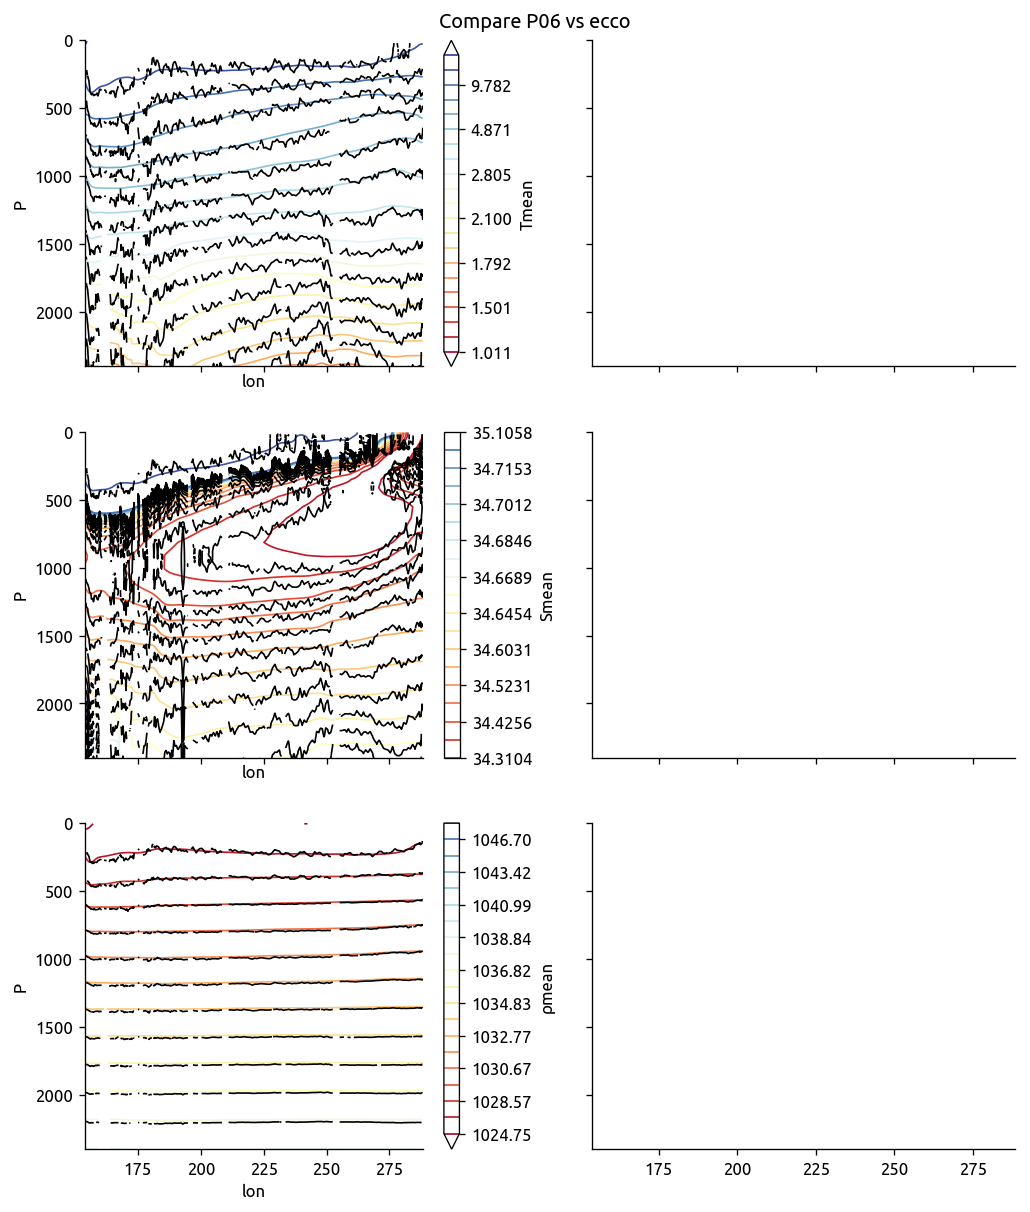

In [179]:
def compare_transect_clim(transect, clim):

    f, ax = plt.subplots(3, 2, sharex=True, sharey=True)

    for aa, (trvar, climvar) in enumerate(zip(['T', 'S', 'rho'], 
                                             ['Tmean', 'Smean', 'ρmean'])):
        _, levels = pd.qcut(transect[trvar].values.ravel(), 20, retbins=True)
        
        (clim[climvar]
         .sel(**ed.get_region_from_transect(p06)).isel(lat=1)
         .plot.contour(ax=ax[aa, 0], levels=levels, x='lon', add_colorbar=True,
                       yincrease=False, cmap=mpl.cm.RdYlBu))
        (transect[trvar]
         .plot.contour(ax=ax[aa, 0], levels=levels, colors='k',
                                      x='lon', y='P', yincrease=False))

    trname = (transect.attrs['transect_name']
              if 'transect_name' in transect.attrs else 'transect')
    f.suptitle('Compare ' + trname + ' vs ' + clim.dataset, y=0.9)
    plt.gcf().set_size_inches((10, 12))


compare_transect_clim(p06, eccograd)
plt.gca().set_ylim((2400, 0))
#  compare_transect_clim(p06, argograd)
# plt.gca().set_ylim((2400, 0))